## Predicts Stock Prices

In [1]:
import quandl
import numpy as np
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

In [2]:
ticker="^NSEI"
#ticker="BTC-USD"
#ticker="GBPUSD=X"
start='2012-01-01'
end='2021-08-01'
end2='2022-04-02'

## Get Stock Data

In [3]:
# getting data using yfinance
stock_data= yf.download(ticker, 
                      start=start, 
                      end=end, 
                      progress=False,
)

df=pd.DataFrame(stock_data["Adj Close"])


In [4]:
## Var for telling prediction for number of days
forecast=130
# Column with space to store predicted prices
df['Prediction']=df["Adj Close"].shift(-forecast)
#df['Prediciton']=df.shift(-1)


In [5]:
## numpy array
X=np.array(df.drop("Prediction", axis = 1))
#Remove the last 'n' rows
X=X[:-forecast]



In [6]:
## Create dependent dataset (Y)
y =np.array(df["Prediction"])
##get all y values minus forecast 
y=y[:-forecast]

In [7]:
# Split the data into training and testing data
x_train,x_test,y_train,y_test= train_test_split(X,y,test_size=0.2)


In [8]:
# Create and train linear Regressor Model
lr=LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [9]:
#testing model(best possible score is 1)
lr_confidence=lr.score(x_test,y_test)
lr_confidence


0.7934835791079609

In [10]:
# Set x_forecast equal to last 20 rows of original data set from Adj Close
x_forecast=np.array(df.drop("Prediction", axis = 1))[-forecast:]

In [11]:
lr_prediction=lr.predict(x_forecast)


In [12]:
## Making new dataframe that contain more data
df2 = yf.download(ticker, 
                      start=start, 
                      end=end2, 
                      progress=False,
)

df2=pd.DataFrame(df2["Adj Close"])


In [13]:
df2=df2.iloc[0:len(df)+forecast]

In [14]:
len(df)

2344

In [15]:
len(df2)

2474

In [16]:
## Create new Dataframe to testing data and then combining forecast data
## pred_df : Predicted Data
pred_df=pd.DataFrame()

In [17]:
pred_df["Date"]=df2.index

In [18]:
a=[]
a=list(df["Adj Close"])
z=list(lr_prediction)

In [19]:
for val in z:
    a.append(val)

In [20]:
b=list(df2["Adj Close"])
for val in b:
    z.append(int(val))

In [21]:
pred_df["Forecast Price"]=(a)
pred_df["Actual Price"]=(b)

In [22]:
plt.plot(pred_df["Actual Price"].tail(400),label="Actual Price")

plt.plot(pred_df["Forecast Price"].tail(400),label="Predicted Price")
plt.legend()
plt.rcParams["figure.figsize"] = (15,12)
plt.figure()
plt.show()

<Figure size 1080x864 with 0 Axes>

## MODEL-I (YEARLY VOLITILITY STATISTICS)

In [23]:
ticker2="^NSEBANK"
start2="2022-01-01"
end2="2022-12-31"

In [24]:
bnf_data= yf.download(ticker2, 
                      start=start2, 
                      end=end2, 
                      progress=False,
)




In [25]:

bnf_data["Daily Change%"] = round((bnf_data["Adj Close"].pct_change(1)) *100,2)
bnf_data.head(6)

Open          High           Low         Close  \
Date                                                                 
2022-01-03  35585.199219  36492.101562  35526.601562  36421.898438   
2022-01-04  36551.250000  36887.800781  36374.398438  36840.148438   
2022-01-05  36943.550781  37862.398438  36756.351562  37695.898438   
2022-01-06  37242.550781  37752.500000  37058.449219  37490.250000   
2022-01-07  37667.050781  38134.851562  37427.800781  37739.601562   
2022-01-10  37930.550781  38400.351562  37929.351562  38347.898438   

               Adj Close  Volume  Daily Change%  
Date                                             
2022-01-03  36421.898438  219000            NaN  
2022-01-04  36840.148438  190500           1.15  
2022-01-05  37695.898438  237400           2.32  
2022-01-06  37490.250000  199000          -0.55  
2022-01-07  37739.601562  183300           0.67  
2022-01-10  38347.898438  206500           1.61

In [26]:
##change greater than 0% but lesser than 1.5%
minorchange=[]
##change greater than 1.5% but lesser than 3%
moderatechange=[]
##change greater than 3% 
extremechange=[]

for i in bnf_data["Daily Change%"]:
    if abs(i)>0 and abs(i)<1.5:
        minorchange.append(abs(i))
    if abs(i)>1.5 and abs(i)<3:
        moderatechange.append(abs(i))
    if abs(i)>3:
        extremechange.append(abs(i))
    

In [27]:
abs(bnf_data["Daily Change%"]).plot(figsize=(15,8),color="purple",label="Daily Change %")

<AxesSubplot:xlabel='Date'>

## MODEL-III (CPR calculation)

In [28]:
######################################### Thesis Behind the model #############################################################################
######### CPR is calculation in which stocks or instruments previous day's high low and closing are calculated 
######### such that we can capture previous day's volitilty and be able too predict what kinfd of market is expected
######### on next trading day .
#####
#####
##### NarrowCpr is considered to be high volatitlity day as it suggests that on previous day instrument experienced big 
###### range movement and instrument might take a rest today as less number of participant will like to involve 
###### in instrument action 

###### WideCpr is considered to be Low volatitlity day as it suggests that on previous day instrument experienced narrow 
###### range movement and instrument might be looking to break ranges as more number of participant will like to involve 
###### in instrument action 


######################################## Formulae of CPR calculation  #####################################################
#########                 daily_pivot = (prevday_high + prevday_low + prevday_close)/3  ###################################   
#########                 daily_bc = (prevday_high + prevday_low)/2                     ###################################
#########                 daily_tc = 2 * daily_pivot - daily_bc                         ###################################
#########                 daily_r1 = 2 * daily_pivot - prevday_low                      ###################################
#########                 daily_r2 = daily_pivot + prevday_high - prevday_low           ################################### 
#########                 daily_r3 = daily_r1 + prevday_high - prevday_low              ###################################
#########                 daily_r4 = daily_r3 + daily_r2 - daily_r1                     ###################################
#########                 daily_s1 = 2 * daily_pivot - prevday_high                     ###################################
#########                 daily_s2 = daily_pivot - prevday_high + prevday_low           ###################################      
#########                 daily_s3 = daily_s1 - prevday_high + prevday_low              ###################################    
#########                 daily_s4 = daily_s3 + daily_s2 - daily_s1                     ################################ 
#######################################################################################################################

In [29]:
### CODE TO GET "end" DATE AS YESTERDAY'S DATE AND "start" DATE AS DATE EXACTLY YEAR FROM "end" DATE
from datetime import datetime as dt
from datetime import timedelta 
todayDate=dt.now().date()
#prevDate=todayDate-timedelta(hours=24)
end2=todayDate
start2=end2-timedelta(days=365)


In [30]:
#### Getting Instrument's Historical Data
ticker="^NSEBANK"
#ticker2="^NSEI"
start=start2
end=end2

df= yf.download(ticker2, 
                      start=start2, 
                      end=end2, 
                      progress=False,
)

## This will only calculate for the next day  

In [31]:
prevday_high=df["High"].iloc[-1]
prevday_close=df["Close"].iloc[-1]
prevday_low=df["Low"].iloc[-1]


daily_pivot = (prevday_high + prevday_low + prevday_close)/3 
daily_bc = (prevday_high + prevday_low)/2                    
daily_tc = 2 * daily_pivot - daily_bc                        
                  

In [32]:
dt=df.iloc[1:len(df)]

Pivot=[]
BottomCentralPivot=[]
TopCentralPivot=[]


## to make calculation on the whole dataframe
for i in range(len(df)):
    #print(df.iloc[i])
    if i==0:
        continue
    else:
        prevday_high=df["High"].iloc[i-1]
        prevday_close=df["Adj Close"].iloc[i-1]
        prevday_low=df["Low"].iloc[i-1]
        
        dailypivot=(prevday_high + prevday_low + prevday_close)/3
        dailybc=(prevday_high + prevday_low)/2 
        dailytc=(2 * dailypivot) - dailybc  
        
        Pivot.append(dailypivot) 
        BottomCentralPivot.append(dailybc)                   
        TopCentralPivot.append(dailytc)
        
        

In [33]:
####Getting the list into DataFrame
dj=pd.DataFrame()
dt["Pivot"]=Pivot
dt["BottomCentralPivot"]=BottomCentralPivot
dt["TopCentralPivot"]=TopCentralPivot


C:\Users\KIIT\AppData\Local\Temp\ipykernel_19344\3672483073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt["Pivot"]=Pivot
C:\Users\KIIT\AppData\Local\Temp\ipykernel_19344\3672483073.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt["BottomCentralPivot"]=BottomCentralPivot
C:\Users\KIIT\AppData\Local\Temp\ipykernel_19344\3672483073.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [34]:
cprdiff=[]
classifer=[]
cprdiffpercent=[]
## CPR CLASSIFICATION AS  NARROW AND WIDE
#find difference between TOP and BOTTOM Pivot
for i in range(len(Pivot)):
    cprdifference=abs(TopCentralPivot[i]-BottomCentralPivot[i])
    cprpercent=abs(round(((cprdifference/BottomCentralPivot[i])*100),2))
    
    cprdiffpercent.append(cprpercent)
    if cprpercent>0.25:
        classifer.append("WIDE")
    else:
        classifer.append("NARROW")
    

In [35]:
dt["cpr%"]=cprdiffpercent
dt["NARROW/WIDE"]=classifer

C:\Users\KIIT\AppData\Local\Temp\ipykernel_19344\1120348366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt["cpr%"]=cprdiffpercent
C:\Users\KIIT\AppData\Local\Temp\ipykernel_19344\1120348366.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt["NARROW/WIDE"]=classifer


In [36]:
#dt.drop(columns=["Volume","Adj Close"],inplace=True)

dt["Daily Change%"] = round((dt["Close"].pct_change(1)) *100,2)
dt.tail(60)

C:\Users\KIIT\AppData\Local\Temp\ipykernel_19344\2267190708.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt["Daily Change%"] = round((dt["Close"].pct_change(1)) *100,2)


Open          High           Low         Close  \
Date                                                                 
2022-05-30  35958.800781  36083.699219  35748.449219  35826.949219   
2022-05-31  35615.300781  35881.949219  35288.949219  35487.398438   
2022-06-01  35358.949219  35768.699219  35285.449219  35620.800781   
2022-06-02  35470.949219  35676.199219  35385.000000  35613.648438   
2022-06-03  35929.550781  35958.449219  35175.101562  35275.050781   
2022-06-06  35159.148438  35424.500000  35072.300781  35310.199219   
2022-06-07  35080.800781  35154.300781  34834.398438  34996.000000   
2022-06-08  35165.648438  35449.898438  34831.750000  34946.148438   
2022-06-09  34802.250000  35149.101562  34659.101562  35085.449219   
2022-06-10  34686.949219  34752.449219  34346.648438  34483.800781   
2022-06-13  33728.648438  33774.050781  33210.351562  33405.851562   
2022-06-14  33180.601562  33618.148438  33123.898438  33311.351562   
2022-06-15  33317.800781  33554.550781  33249.550781  33339.000000   
2022-06-16  33648.800781  33756.500000  32537.949219  32617.099609   
2022-06-17  32393.449219  32889.800781  32290.550781  32743.050781   
2022-06-20  32873.398438  32926.101562  32426.400391  32684.800781   
2022-06-21  32978.050781  33593.800781  32797.550781  33191.750000   
2022-06-22  33051.648438  33106.949219  32758.150391  32845.300781   
2022-06-23  32927.398438  33431.750000  32652.150391  33135.000000   
2022-06-24  33434.800781  33721.898438  33390.851562  33627.449219   
2022-06-27  34126.199219  34147.500000  33735.500000  33811.250000   
2022-06-28  33578.199219  33745.300781  33503.300781  33642.449219   
2022-06-29  33273.550781  33422.800781  33185.250000  33269.898438   
2022-06-30  33180.699219  33659.300781  33179.601562  33425.101562   
2022-07-01  33264.750000  33666.500000  33080.449219  33539.449219   
2022-07-04  33558.851562  33978.500000  33515.601562  33940.898438   
2022-07-05  34084.699219  34361.050781  33757.000000  33815.898438   
2022-07-06  33929.398438  34388.500000  33876.148438  34324.250000   
2022-07-07  34627.398438  34965.750000  34553.101562  34920.300781   
2022-07-08  35258.898438  35262.101562  34977.750000  35124.050781   
2022-07-11  35017.601562  35543.101562  35006.550781  35469.648438   
2022-07-12  35298.699219  35419.648438  35047.500000  35132.250000   
2022-07-13  35259.800781  35308.148438  34757.601562  34827.800781   
2022-07-14  34817.949219  35027.601562  34558.449219  34651.199219   
2022-07-15  34734.449219  34899.949219  34463.898438  34682.648438   
2022-07-18  34841.851562  35382.500000  34804.398438  35358.699219   
2022-07-19  35113.250000  35761.648438  35110.500000  35720.351562   
2022-07-20  36061.300781  36182.699219  35876.550781  35972.101562   
2022-07-21  36026.550781  36331.699219  35887.351562  36201.000000   
2022-07-22  36322.898438  36823.449219  36286.351562  36738.949219   
2022-07-25  36766.699219  37011.199219  36464.648438  36726.398438   
2022-07-26  36688.550781  36695.750000  36334.101562  36408.500000   
2022-07-27  36370.550781  36808.300781  36248.601562  36783.750000   
2022-07-28  37102.449219  37414.398438  37028.500000  37378.148438   
2022-07-29  37717.300781  37754.648438  37221.148438  37491.398438   
2022-08-01  37594.148438  37939.601562  37407.199219  37903.199219   
2022-08-02  37767.699219  38179.851562  37632.300781  38024.000000   
2022-08-03  37954.550781  38068.601562  37692.949219  37989.250000   
2022-08-04  38111.050781  38231.851562  37249.500000  37755.550781   
2022-08-05  37868.250000  38150.449219  37779.898438  37920.601562   
2022-08-08  37847.351562  38302.351562  37681.449219  38237.398438   
2022-08-10  38298.851562  38402.949219  38155.300781  38287.851562   
2022-08-11  38712.949219  38932.101562  38648.898438  38879.851562   
2022-08-12  38942.449219  39088.898438  38739.949219  39042.300781   
2022-08-16  39284.101562  39444.601562  39119.898438  39239.648438   
2022-08-17  39351.300781  3950

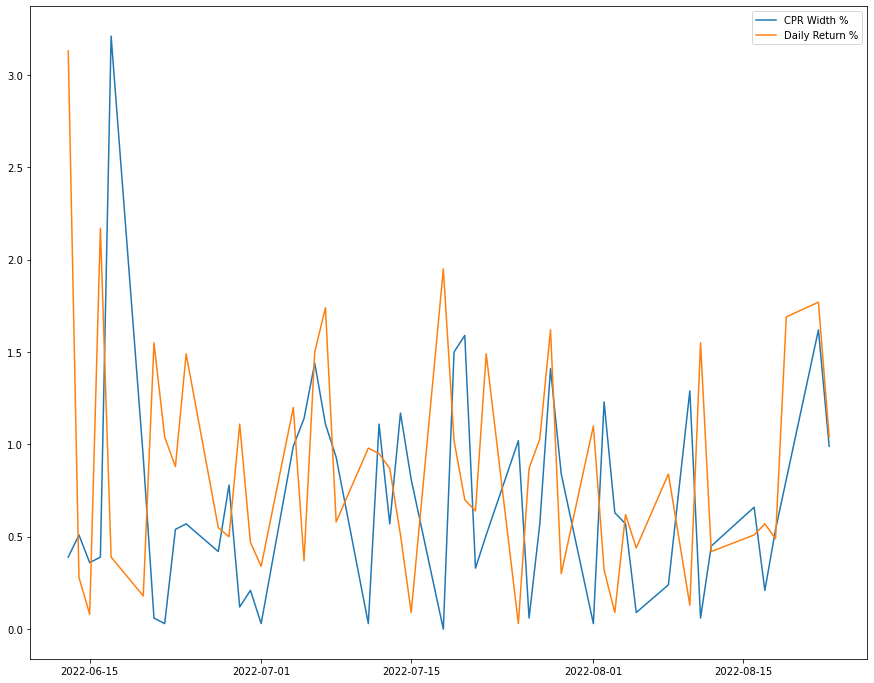

<Figure size 576x360 with 0 Axes>

In [37]:
#####just to help in visualization cpr% is multipied by 3 
plt.plot((dt["cpr%"]*3).tail(50),label="CPR Width %")
plt.plot(abs(dt["Daily Change%"]).tail(50),label="Daily Return %")
plt.legend()
plt.rcParams["figure.figsize"] = (8,5)
plt.figure()
plt.show()

In [38]:
decaymarket=[]
countfalse=0
countnarrow=0
countwide=0
for i in range(len(dt)):
    if dt["NARROW/WIDE"].iloc[i]=="NARROW" and abs(dt["Daily Change%"].iloc[i-1])<0.7:
        decaymarket.append("NARROW OVERALL")
        countnarrow=countnarrow+1
        
    elif dt["NARROW/WIDE"].iloc[i]=="WIDE" and abs(dt["Daily Change%"].iloc[i-1])>0.7:
        decaymarket.append("WIDE OVERALL")
        countwide=countwide+1
    else:
        decaymarket.append(False)
        countfalse=countfalse+1

In [39]:
### Probability of Expected Range
ProbabiltyTrueExpectation=(countwide+countnarrow)/len(dt)
print(round(ProbabiltyTrueExpectation,2))

0.66


In [40]:
### Probability of Event when thesis failed
ProbabiltyFalseExpectation=countfalse/len(dt)
print(round(ProbabiltyFalseExpectation,2))

0.34


In [41]:
###### Conclusion : From the Above graph and probabilty theory, we can conclude that in most cases when the 
#                   CPR% grapth make a trough , there is crest formation in the DailyChange% graph which indicates 
#                   instrument activity shoot up after a low range day and viceversa. 
                  

## MODEL- III (TRADING MODEL BASED ON ABOVE THESIS)

In [42]:
### BASEDON ABOVE RESULT , MODEL CAN BE CREATED WHICH WILL USE A SIMPLE TREND FOLLOWING SYSTEM AND WILL ONLY WORK ON
### DAYS ON WHICH WE WILL GET SIGNAL TO TRADE FROM ABOVE MODEL
### EXPECTATION ARE THAT WE WILL NOT PARTICIPATE ON CHOPPY DAYS 
### TWO TYPES OF COMPARISON OF RESULTS WILL BE THERE :-
###           1.Against OVERALL DF
###           2.Against WIDE CLASSIFED DAYS (AS SYSTEM BEING USED IS TREND FOLLOWING) 

In [43]:
### CODE TO GET "end" DATE AS YESTERDAY'S DATE AND "start" DATE AS DATE EXACTLY YEAR FROM "end" DATE
from datetime import datetime as dt
from datetime import timedelta 
todayDate=dt.now().date()
#prevDate=todayDate-timedelta(hours=24)
end2=todayDate
start2=end2-timedelta(days=365)
start2="2022-01-01"

In [44]:
#### Getting Instrument's Historical Data
ticker2="^NSEBANK"
#ticker2="^NSEI"
#ticker2="RELIANCE.NS"
#ticker2="^DJI"
start=start2
end=end2

df1= yf.download(ticker2, 
                      start=start2, 
                      end=end2, 
                      progress=False,
)


In [45]:
df1.head(6)

Open          High           Low         Close  \
Date                                                                 
2022-01-03  35585.199219  36492.101562  35526.601562  36421.898438   
2022-01-04  36551.250000  36887.800781  36374.398438  36840.148438   
2022-01-05  36943.550781  37862.398438  36756.351562  37695.898438   
2022-01-06  37242.550781  37752.500000  37058.449219  37490.250000   
2022-01-07  37667.050781  38134.851562  37427.800781  37739.601562   
2022-01-10  37930.550781  38400.351562  37929.351562  38347.898438   

               Adj Close  Volume  
Date                              
2022-01-03  36421.898438  219000  
2022-01-04  36840.148438  190500  
2022-01-05  37695.898438  237400  
2022-01-06  37490.250000  199000  
2022-01-07  37739.601562  183300  
2022-01-10  38347.898438  206500

In [46]:
prevday_high=df1["High"].iloc[-1]
prevday_close=df1["Close"].iloc[-1]
prevday_low=df1["Low"].iloc[-1]


daily_pivot = (prevday_high + prevday_low + prevday_close)/3 
daily_bc = (prevday_high + prevday_low)/2                    
daily_tc = 2 * daily_pivot - daily_bc                        
                  

In [48]:
## CPR CLASSIFICATION AS  NARROW AND WIDE(TO PREDICT NEXT DAY RANGE EXPECTATION)
#find difference between TOP and BOTTOM Pivot
nextdayclassifier=None
cprdifference=abs(daily_tc-daily_bc)
cprpercent=abs(round(((cprdifference/daily_bc)*100),2))


if cprpercent>0.3:
    nextdayclassifier=("WIDE")
else:
    nextdayclassifier=("NARROW")


#### BACTESTING MODEL AND DATASET CREATION

In [49]:
dt1=df1.iloc[1:len(df1)]

Pivot=[]
BottomCentralPivot=[]
TopCentralPivot=[]


## to make calculation on the whole dataframe
for i in range(len(df1)):
    #print(df1.iloc[i])
    if i==0:
        Pivot.append("NaN") 
        BottomCentralPivot.append("NaN")                   
        TopCentralPivot.append("NaN")
    
    else:
        prevday_high=df1["High"].iloc[i-1]
        prevday_close=df1["Adj Close"].iloc[i-1]
        prevday_low=df1["Low"].iloc[i-1]
        
        dailypivot=(prevday_high + prevday_low + prevday_close)/3
        dailybc=(prevday_high + prevday_low)/2 
        dailytc=(2 * dailypivot) - dailybc  
        
        Pivot.append(dailypivot) 
        BottomCentralPivot.append(dailybc)                   
        TopCentralPivot.append(dailytc)
        
        

In [50]:
####Getting the list into DataFrame
Pivot.pop()
BottomCentralPivot.pop()
TopCentralPivot.pop()
dt1["Pivot"]=Pivot
dt1["BottomCentralPivot"]=BottomCentralPivot
dt1["TopCentralPivot"]=TopCentralPivot


C:\Users\KIIT\AppData\Local\Temp\ipykernel_19344\602333233.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt1["Pivot"]=Pivot
C:\Users\KIIT\AppData\Local\Temp\ipykernel_19344\602333233.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt1["BottomCentralPivot"]=BottomCentralPivot
C:\Users\KIIT\AppData\Local\Temp\ipykernel_19344\602333233.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [51]:
cprdiff=[]
classifer=[]
cprdiffpercent=[]
## CPR CLASSIFICATION AS  NARROW AND WIDE
#find difference between TOP and BOTTOM Pivot
for i in range(len(Pivot)):
    if i==0:
        cprdiffpercent.append("NaN")
        classifer.append("NaN")
    else:
        cprdifference=abs(TopCentralPivot[i]-BottomCentralPivot[i])
        cprpercent=abs(round(((cprdifference/BottomCentralPivot[i])*100),2))
        
        cprdiffpercent.append(cprpercent)
        if cprpercent>0.25:
            classifer.append("WIDE")
        else:
            classifer.append("NARROW")
        

In [52]:
#classifer.pop()
#cprdiffpercent.pop()
dt1["cpr%"]=cprdiffpercent
dt1["NARROW/WIDE"]=classifer

C:\Users\KIIT\AppData\Local\Temp\ipykernel_19344\2585556479.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt1["cpr%"]=cprdiffpercent
C:\Users\KIIT\AppData\Local\Temp\ipykernel_19344\2585556479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt1["NARROW/WIDE"]=classifer


In [53]:
#dt1.drop(columns=["Volume","Adj Close"],inplace=True)

dt1["Daily Change%"] = round((dt1["Close"].pct_change(1)) *100,2)
dt1.tail(6)

C:\Users\KIIT\AppData\Local\Temp\ipykernel_19344\1037477515.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt1["Daily Change%"] = round((dt1["Close"].pct_change(1)) *100,2)


Open          High           Low         Close  \
Date                                                                 
2022-08-16  39284.101562  39444.601562  39119.898438  39239.648438   
2022-08-17  39351.300781  39504.500000  39202.800781  39461.699219   
2022-08-18  39324.398438  39703.699219  39291.148438  39656.148438   
2022-08-19  39732.648438  39759.148438  38848.398438  38985.949219   
2022-08-22  38693.648438  38732.851562  38247.250000  38297.750000   
2022-08-23  37955.449219  38869.898438  37950.851562  38697.648438   

               Adj Close  Volume         Pivot BottomCentralPivot  \
Date                                                                
2022-08-16  39239.648438       0  38820.283854            38790.5   
2022-08-17  39461.699219  169800  38957.049479       38914.423828   
2022-08-18  39656.148438  137200  39268.049479           39282.25   
2022-08-19  38985.949219  148100  39389.666667       39353.650391   
2022-08-22  38297.750000  124300  39550.332031       39497.423828   
2022-08-23  38697.648438  176400  39197.832031       39303.773438   

           TopCentralPivot  cpr% NARROW/WIDE  Daily Change%  
Date                                                         
2022-08-16    38850.067708  0.15      NARROW           0.51  
2022-08-17     38999.67513  0.22      NARROW           0.57  
2022-08-18    39253.848958  0.07      NARROW           0.49  
2022-08-19    39425.682943  0.18      NARROW          -1.69  
2022-08-22    39603.240234  0.27        WIDE          -1.77  
2022-08-23    39091.890625  0.54        WIDE           1.04

# PART1: TESTING WITH HELP OF CLASSIFIER

In [54]:
### TREND FOLLOWING STRATEGY BASIS :
### ENTRY ABOVE/BELOW VWAP 
### SL- CLOSE BASIS and not beyond 0.75% from OPEN

In [55]:
import talib as tl
dt1["MA25"] = tl.MA(dt1["Close"], timeperiod=10, matype=0)

C:\Users\KIIT\AppData\Local\Temp\ipykernel_19344\4197794423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt1["MA25"] = tl.MA(dt1["Close"], timeperiod=10, matype=0)


In [56]:
dt1.head(6)

Open          High           Low         Close  \
Date                                                                 
2022-01-04  36551.250000  36887.800781  36374.398438  36840.148438   
2022-01-05  36943.550781  37862.398438  36756.351562  37695.898438   
2022-01-06  37242.550781  37752.500000  37058.449219  37490.250000   
2022-01-07  37667.050781  38134.851562  37427.800781  37739.601562   
2022-01-10  37930.550781  38400.351562  37929.351562  38347.898438   
2022-01-11  38370.000000  38504.601562  38031.750000  38442.199219   

               Adj Close  Volume         Pivot BottomCentralPivot  \
Date                                                                
2022-01-04  36840.148438  190500           NaN                NaN   
2022-01-05  37695.898438  237400  36146.867188       36009.351562   
2022-01-06  37490.250000  199000  36700.782552       36631.099609   
2022-01-07  37739.601562  183300  37438.216146          37309.375   
2022-01-10  38347.898438  206500  37433.733073       37405.474609   
2022-01-11  38442.199219  159500  37767.417969       37781.326172   

           TopCentralPivot  cpr% NARROW/WIDE  Daily Change%  MA25  
Date                                                               
2022-01-04             NaN   NaN         NaN            NaN   NaN  
2022-01-05    36284.382812  0.76        WIDE           2.32   NaN  
2022-01-06    36770.465495  0.38        WIDE          -0.55   NaN  
2022-01-07    37567.057292  0.69        WIDE           0.67   NaN  
2022-01-10    37461.991536  0.15      NARROW           1.61   NaN  
2022-01-11    37753.509766  0.07      NARROW           0.25   NaN

In [57]:
tradetaken=[]
pointsmade=[]
positionType=[]
pnltype=[]
tradedate=[]
classifier=[]

for i in range(len(dt1)):
    Open=dt1["Open"].iloc[i]
    High=dt1["High"].iloc[i]
    Low=dt1["Low"].iloc[i]
    Close=dt1["Close"].iloc[i]
    MA25=dt1["MA25"].iloc[i]
    Classifier=dt1["NARROW/WIDE"].iloc[i]
    classifierpoint=0
    if MA25=="NaN" or Classifier=="WIDE":
        tradetaken.append("NO")
        pointsmade.append(0)
        positionType.append("NaN")
        pnltype.append("NaN")
        tradedate.append(dt1.index[i])
        
    else:
        tradedate.append(dt1.index[i])
        if Open>MA25:
            if Open-((Open)*0.7)/100 < Low:
                
                tradetaken.append("YES")
                pointsmade.append(Close-Open)
                classifierpoint=Close-Open
                positionType.append("BUY")
                if Close-Open>0:
                    pnltype.append("Profit")
                else:
                    pnltype.append("Loss")
                    
            elif Open-((Open)*0.7)/100 > Low:
                tradetaken.append("YES")
                pointsmade.append((((Open)*0.7)/100)*-1)
                classifierpoint=((((Open)*0.7)/100)*-1)
                positionType.append("BUY")
                pnltype.append("Loss")
                
        elif Open<MA25 :
            if Open+((Open)*0.7)/100 > High:
                tradetaken.append("YES")
                pointsmade.append(Open-Close)
                classifierpoint=(Open-Close)
                positionType.append("SELL")
                if Open-Close>0:
                    pnltype.append("Profit")
                else:
                    pnltype.append("Loss")
                
            elif Open+((Open)*0.7)/100 < High:
                tradetaken.append("YES")
                pointsmade.append((((Open)*0.7)/100)*-1)
                classifierpoint=((((Open)*0.7)/100)*-1)
                positionType.append("SELL")
                pnltype.append("Loss")
        else:
            tradetaken.append("NaN")
            pointsmade.append(0)
            positionType.append("NaN")
            pnltype.append("NaN")
        
    classifier.append(round(classifierpoint,2))
                
    
    

In [58]:
dt1["WithClassifier"]=classifier

C:\Users\KIIT\AppData\Local\Temp\ipykernel_19344\1174159228.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt1["WithClassifier"]=classifier


In [59]:

  
# dictionary of lists 
dict = {"TradeDate":tradedate,'TradeTaken': tradetaken, 'Points': pointsmade, 'Position': positionType,"PnL": pnltype} 
    
tradeledger1 = pd.DataFrame(dict)

In [60]:
tradeledger1.tail(5)

TradeDate TradeTaken      Points Position     PnL
153 2022-08-17        YES  110.398438      BUY  Profit
154 2022-08-18        YES  331.750000      BUY  Profit
155 2022-08-19        YES -278.128539      BUY    Loss
156 2022-08-22         NO    0.000000      NaN     NaN
157 2022-08-23         NO    0.000000      NaN     NaN

In [61]:
sum(pointsmade)

1105.8089921875

In [62]:
tradeledger1["Points"].plot(figsize=(10,8),color="purple")


<AxesSubplot:>

## MODEL TESTING WITHOUT HELP OF CLASSIFIER

In [63]:
dt2=dt1

In [64]:
tradetaken=[]
pointsmade=[]
positionType=[]
pnltype=[]
nonclassifier=[]
date=[]

for i in range(len(dt2)):
    Open=dt2["Open"].iloc[i]
    High=dt2["High"].iloc[i]
    Low=dt2["Low"].iloc[i]
    Close=dt2["Close"].iloc[i]
    MA25=dt2["MA25"].iloc[i]
    nonclassifierpoint=0
    
    
    if MA25=="NaN" :
        tradetaken.append("NO")
        pointsmade.append(0)
        positionType.append("NaN")
        pnltype.append("NaN")
    else:
        if Open>MA25:
            if Open-((Open)*0.7)/100 < Low:
                tradetaken.append("YES")
                pointsmade.append(Close-Open)
                nonclassifierpoint=(Close-Open)
                positionType.append("BUY")
                if Close-Open>0:
                    pnltype.append("Profit")
                else:
                    pnltype.append("Loss")
                    
            elif Open-((Open)*0.7)/100 > Low:
                tradetaken.append("YES")
                pointsmade.append((((Open)*0.7)/100)*-1)
                nonclassifierpoint=((((Open)*0.7)/100)*-1)
                positionType.append("BUY")
                pnltype.append("Loss")
                
        elif Open<MA25 :
            if Open+((Open)*0.7)/100 > High:
                tradetaken.append("YES")
                pointsmade.append(Open-Close)
                nonclassifierpoint=(Open-Close)
                positionType.append("SELL")
                if Open-Close>0:
                    pnltype.append("Profit")
                else:
                    pnltype.append("Loss")
                
            elif Open+((Open)*0.7)/100 < High:
                tradetaken.append("YES")
                pointsmade.append((((Open)*0.7)/100)*-1)
                nonclassifierpoint=((((Open)*0.7)/100)*-1)
                positionType.append("SELL")
                pnltype.append("Loss")
        else:
            tradetaken.append("NaN")
            pointsmade.append(0)
            positionType.append("NaN")
            pnltype.append("NaN")
        nonclassifier.append(round(nonclassifierpoint,2))
        date.append(dt2.index[i])
    
    

In [65]:
dt1["Without Classifier"]=nonclassifier

C:\Users\KIIT\AppData\Local\Temp\ipykernel_19344\2780569704.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt1["Without Classifier"]=nonclassifier


In [66]:
dict = {"Date" : date,'TradeTaken': tradetaken, 'Points': pointsmade, 'Position': positionType,"PnL": pnltype} 
    
tradeledger2 = pd.DataFrame(dict)

In [67]:
(tradeledger2.dropna(axis=1,inplace=True))
tradeledger2

Date TradeTaken      Points Position     PnL
0   2022-01-04        NaN    0.000000      NaN     NaN
1   2022-01-05        NaN    0.000000      NaN     NaN
2   2022-01-06        NaN    0.000000      NaN     NaN
3   2022-01-07        NaN    0.000000      NaN     NaN
4   2022-01-10        NaN    0.000000      NaN     NaN
..         ...        ...         ...      ...     ...
153 2022-08-17        YES  110.398438      BUY  Profit
154 2022-08-18        YES  331.750000      BUY  Profit
155 2022-08-19        YES -278.128539      BUY    Loss
156 2022-08-22        YES  395.898438     SELL  Profit
157 2022-08-23        YES -265.688145     SELL    Loss

[158 rows x 5 columns]

In [68]:
sum(pointsmade)

414.1558105468766

<AxesSubplot:>

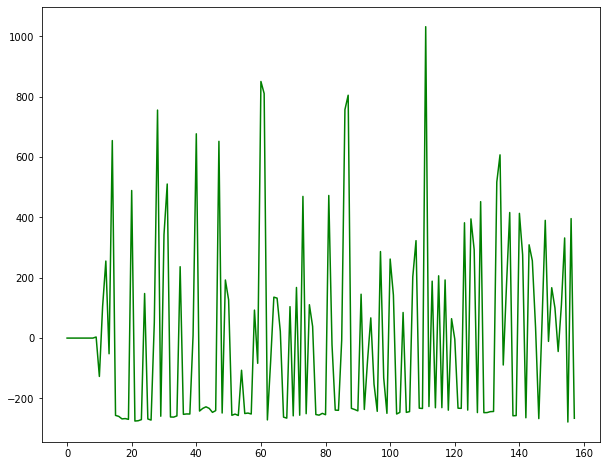

In [69]:
tradeledger2["Points"].plot(figsize=(10,8),color="green")

In [70]:
plt.plot(tradeledger2["Points"],color="green",label="Non-Classied Trade")
plt.plot(tradeledger1["Points"],color="purple",label="Classified Trade")
plt.legend()
plt.rcParams["figure.figsize"] = (15,12)
plt.figure()
plt.show()

<Figure size 1080x864 with 0 Axes>

In [71]:
total=sum(tradeledger1["Points"])

In [72]:
margin=120000
percentage_ret=((((total)))*25/margin)*100

In [73]:
percentage_ret

23.037687337239586

## QUANTITATIVE ANALYSIS

In [74]:
###tradelegder1 contains data with classifier model
###tradeledger2 contains data without classifier model

In [75]:
dt1.head(6)

Open          High           Low         Close  \
Date                                                                 
2022-01-04  36551.250000  36887.800781  36374.398438  36840.148438   
2022-01-05  36943.550781  37862.398438  36756.351562  37695.898438   
2022-01-06  37242.550781  37752.500000  37058.449219  37490.250000   
2022-01-07  37667.050781  38134.851562  37427.800781  37739.601562   
2022-01-10  37930.550781  38400.351562  37929.351562  38347.898438   
2022-01-11  38370.000000  38504.601562  38031.750000  38442.199219   

               Adj Close  Volume         Pivot BottomCentralPivot  \
Date                                                                
2022-01-04  36840.148438  190500           NaN                NaN   
2022-01-05  37695.898438  237400  36146.867188       36009.351562   
2022-01-06  37490.250000  199000  36700.782552       36631.099609   
2022-01-07  37739.601562  183300  37438.216146          37309.375   
2022-01-10  38347.898438  206500  37433.733073       37405.474609   
2022-01-11  38442.199219  159500  37767.417969       37781.326172   

           TopCentralPivot  cpr% NARROW/WIDE  Daily Change%  MA25  \
Date                                                                
2022-01-04             NaN   NaN         NaN            NaN   NaN   
2022-01-05    36284.382812  0.76        WIDE           2.32   NaN   
2022-01-06    36770.465495  0.38        WIDE          -0.55   NaN   
2022-01-07    37567.057292  0.69        WIDE           0.67   NaN   
2022-01-10    37461.991536  0.15      NARROW           1.61   NaN   
2022-01-11    37753.509766  0.07      NARROW           0.25   NaN   

            WithClassifier  Without Classifier  
Date                                            
2022-01-04             0.0                 0.0  
2022-01-05             0.0                 0.0  
2022-01-06             0.0                 0.0  
2022-01-07             0.0                 0.0  
2022-01-10             0.0                 0.0  
2022-01-11             0.0                 0.0

In [76]:
#### setting the margin
margin1=dt1["Open"].iloc[0]
margin2=dt1["Open"].iloc[0]
kpi=pd.DataFrame()

In [77]:
Classifierreturn=[]
NonClassifierreturn=[]
for i in range(len(dt1)):
    # For Calculating returns with Classifier Model
    margin1=dt1["WithClassifier"].iloc[i]+margin1
    Classifierreturn.append(round(margin1,2))
    margin2=dt1["Without Classifier"].iloc[i]+margin2
    NonClassifierreturn.append(round(margin2,2))
    

In [78]:
kpi["Classifier"]=pd.DataFrame(Classifierreturn)
kpi["Non-Classifier"]=pd.DataFrame(NonClassifierreturn)
a=list(dt1["Close"])


In [79]:
kpi.head(5)

Classifier  Non-Classifier
0    36551.25        36551.25
1    36551.25        36551.25
2    36551.25        36551.25
3    36551.25        36551.25
4    36551.25        36551.25

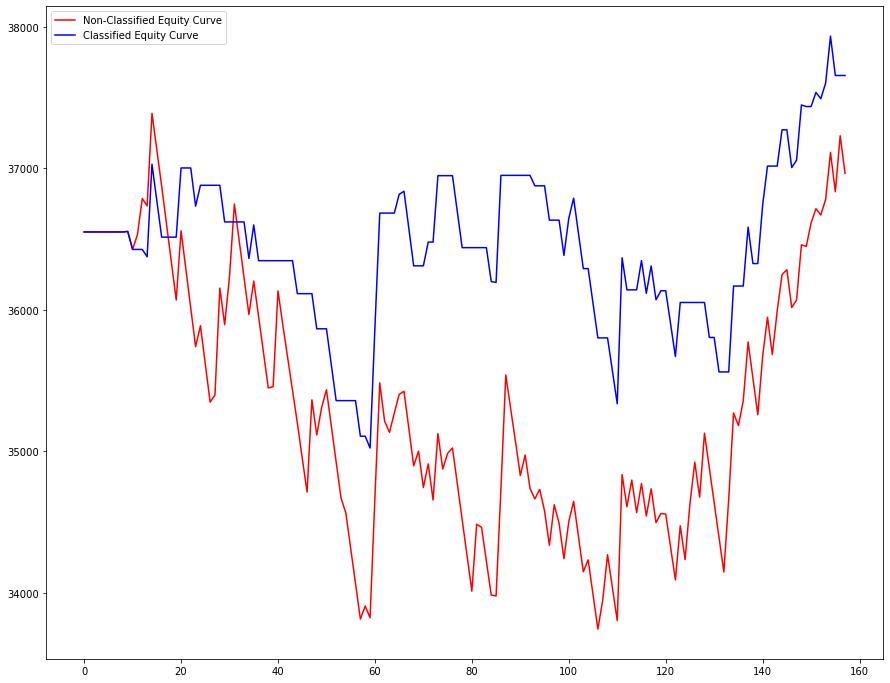

<Figure size 1080x864 with 0 Axes>

In [80]:
plt.plot(kpi["Non-Classifier"],color="red",label="Non-Classified Equity Curve")
plt.plot(kpi["Classifier"],color="blue",label="Classified Equity Curve")

plt.legend()
plt.rcParams["figure.figsize"] = (15,12)
plt.figure()
plt.show()




In [81]:
dt1.head(5)

Open          High           Low         Close  \
Date                                                                 
2022-01-04  36551.250000  36887.800781  36374.398438  36840.148438   
2022-01-05  36943.550781  37862.398438  36756.351562  37695.898438   
2022-01-06  37242.550781  37752.500000  37058.449219  37490.250000   
2022-01-07  37667.050781  38134.851562  37427.800781  37739.601562   
2022-01-10  37930.550781  38400.351562  37929.351562  38347.898438   

               Adj Close  Volume         Pivot BottomCentralPivot  \
Date                                                                
2022-01-04  36840.148438  190500           NaN                NaN   
2022-01-05  37695.898438  237400  36146.867188       36009.351562   
2022-01-06  37490.250000  199000  36700.782552       36631.099609   
2022-01-07  37739.601562  183300  37438.216146          37309.375   
2022-01-10  38347.898438  206500  37433.733073       37405.474609   

           TopCentralPivot  cpr% NARROW/WIDE  Daily Change%  MA25  \
Date                                                                
2022-01-04             NaN   NaN         NaN            NaN   NaN   
2022-01-05    36284.382812  0.76        WIDE           2.32   NaN   
2022-01-06    36770.465495  0.38        WIDE          -0.55   NaN   
2022-01-07    37567.057292  0.69        WIDE           0.67   NaN   
2022-01-10    37461.991536  0.15      NARROW           1.61   NaN   

            WithClassifier  Without Classifier  
Date                                            
2022-01-04             0.0                 0.0  
2022-01-05             0.0                 0.0  
2022-01-06             0.0                 0.0  
2022-01-07             0.0                 0.0  
2022-01-10             0.0                 0.0

In [82]:
#### month assignment
i=0
month=[]
monthdig=None
for i in range(len(dt1)):
    monthdig=(str(dt1.index[i]).split("-")[1])
    if monthdig=="01":
        month.append("Jan")
    if monthdig=="02":
        month.append("Feb")
    if monthdig=="03":
        month.append("Mar")
    if monthdig=="04":
        month.append("Apr")
    if monthdig=="05":
        month.append("May")
    if monthdig=="06":
        month.append("Jun")
    if monthdig=="07":
        month.append("Jul")
    if monthdig=="08":
        month.append("Aug")
    if monthdig=="09":
        month.append("Sep")
    if monthdig=="10":
        month.append("Oct")
    if monthdig=="11":
        month.append("Nov")
    if monthdig=="12":
        month.append("Dec")
        

In [83]:
dt1["Month"]=pd.DataFrame(month)
kpi["Month"]=pd.DataFrame(month)

C:\Users\KIIT\AppData\Local\Temp\ipykernel_19344\1841547482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt1["Month"]=pd.DataFrame(month)


In [84]:
dt1.head(5)

Open          High           Low         Close  \
Date                                                                 
2022-01-04  36551.250000  36887.800781  36374.398438  36840.148438   
2022-01-05  36943.550781  37862.398438  36756.351562  37695.898438   
2022-01-06  37242.550781  37752.500000  37058.449219  37490.250000   
2022-01-07  37667.050781  38134.851562  37427.800781  37739.601562   
2022-01-10  37930.550781  38400.351562  37929.351562  38347.898438   

               Adj Close  Volume         Pivot BottomCentralPivot  \
Date                                                                
2022-01-04  36840.148438  190500           NaN                NaN   
2022-01-05  37695.898438  237400  36146.867188       36009.351562   
2022-01-06  37490.250000  199000  36700.782552       36631.099609   
2022-01-07  37739.601562  183300  37438.216146          37309.375   
2022-01-10  38347.898438  206500  37433.733073       37405.474609   

           TopCentralPivot  cpr% NARROW/WIDE  Daily Change%  MA25  \
Date                                                                
2022-01-04             NaN   NaN         NaN            NaN   NaN   
2022-01-05    36284.382812  0.76        WIDE           2.32   NaN   
2022-01-06    36770.465495  0.38        WIDE          -0.55   NaN   
2022-01-07    37567.057292  0.69        WIDE           0.67   NaN   
2022-01-10    37461.991536  0.15      NARROW           1.61   NaN   

            WithClassifier  Without Classifier Month  
Date                                                  
2022-01-04             0.0                 0.0   NaN  
2022-01-05             0.0                 0.0   NaN  
2022-01-06             0.0                 0.0   NaN  
2022-01-07             0.0                 0.0   NaN  
2022-01-10             0.0                 0.0   NaN

#### Monthly Return of Non- Classifier Model

In [85]:

month=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
for j in month:
    monthwise=0
    count=0
    
    for i in range(len(dt1)):
        if kpi["Month"].iloc[i]==j:
            monthwise=monthwise+dt1["WithClassifier"].iloc[i]
            count=count+1
            #print("1")
    globals()[f"{j}monthwise"]=round(monthwise,2)
    print(j)
    print(f"Points Captured in {j} = "+str(globals()[f"{j}monthwise"]))
    globals()[f"{j}count"]=count
    print(f"Numbers of Trade Taken in {j} = "+str(globals()[f"{j}count"]))
    
    print("____________________________________________________________")



Jan
Points Captured in Jan = -36.65
Numbers of Trade Taken in Jan = 19
____________________________________________________________
Feb
Points Captured in Feb = -166.4
Numbers of Trade Taken in Feb = 20
____________________________________________________________
Mar
Points Captured in Mar = -1324.0
Numbers of Trade Taken in Mar = 21
____________________________________________________________
Apr
Points Captured in Apr = 1416.19
Numbers of Trade Taken in Apr = 19
____________________________________________________________
May
Points Captured in May = -54.97
Numbers of Trade Taken in May = 21
____________________________________________________________
Jun
Points Captured in Jun = -481.76
Numbers of Trade Taken in Jun = 22
____________________________________________________________
Jul
Points Captured in Jul = 1113.06
Numbers of Trade Taken in Jul = 21
____________________________________________________________
Aug
Points Captured in Aug = 640.34
Numbers of Trade Taken in Aug = 15
_

#### Monthly Return of Non- Classifier Model

In [86]:

month=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
for j in month:
    monthwise=0
    count=0
    
    for i in range(len(dt1)):
        if kpi["Month"].iloc[i]==j:
            monthwise=monthwise+dt1["Without Classifier"].iloc[i]
            count=count+1
            #print("1")
    globals()[f"{j}monthwise"]=round(monthwise,2)
    print(j)
    print(f"Points Captured in {j} = "+str(globals()[f"{j}monthwise"]))
    globals()[f"{j}count"]=count
    print(f"Numbers of Trade Taken in {j} = "+str(globals()[f"{j}count"]))
    
    print("____________________________________________________________")



Jan
Points Captured in Jan = -211.37
Numbers of Trade Taken in Jan = 19
____________________________________________________________
Feb
Points Captured in Feb = -891.0
Numbers of Trade Taken in Feb = 20
____________________________________________________________
Mar
Points Captured in Mar = -1624.41
Numbers of Trade Taken in Mar = 21
____________________________________________________________
Apr
Points Captured in Apr = 691.78
Numbers of Trade Taken in Apr = 19
____________________________________________________________
May
Points Captured in May = -273.87
Numbers of Trade Taken in May = 21
____________________________________________________________
Jun
Points Captured in Jun = 83.09
Numbers of Trade Taken in Jun = 22
____________________________________________________________
Jul
Points Captured in Jul = 1358.76
Numbers of Trade Taken in Jul = 21
____________________________________________________________
Aug
Points Captured in Aug = 1281.2
Numbers of Trade Taken in Aug = 15
_

#### Performance Report of Classifier Model

In [87]:
## Number of Trades Taken 
tradenum=0
profit=0
profitsum=0
loss=0
losssum=0
maxpoint=0
minpoint=0
for i in tradeledger1["Points"]:
    if i>0 or i<0:
        tradenum=tradenum+1
        if i>0:
            profit=profit+1
            profitsum=profitsum+i
            if maxpoint<i:
                maxpoint=i
        if i<0:
            loss=loss+1
            losssum=losssum+i
            
            if minpoint>i:
                minpoint=i
            



#### Prepaing the Standard Report 

In [88]:
print("Number of Trades Taken :\t\t\t"+str(tradenum))
print("Number of Profitable Position:  \t\t"+str(profit))
print("Number of Unprofitable Position :\t\t"+str(loss))
print("Net Profit : \t\t\t\t\t"+str(round(profitsum+losssum,2)))
print("Total Points made with Profitable Positions :  \t"+str(round(profitsum,2)))
print("Total Points made with Unprofitable Positions :"+str(round(losssum,2)))
print("Average Profitable Trade : \t\t\t"+str(round((profitsum/profit),2)))
print("Average Unprofitable Trade : \t\t\t"+str(round((losssum/loss),2)))
print("Winner to Loser Ratio :\t\t\t\t"+str(round((profit/loss),2)))
print("Largest Profitable Position :\t\t\t"+str(round(maxpoint,2)))
print("Largest Unprofitable Position :\t\t\t"+str(round(minpoint,2)))

Number of Trades Taken :			70
Number of Profitable Position:  		29
Number of Unprofitable Position :		41
Net Profit : 					1105.81
Total Points made with Profitable Positions :  	9974.25
Total Points made with Unprofitable Positions :-8868.44
Average Profitable Trade : 			343.94
Average Unprofitable Trade : 			-216.3
Winner to Loser Ratio :				0.71
Largest Profitable Position :			1031.7
Largest Unprofitable Position :			-278.13


#### Performance Report of Non- Classifier Model

In [89]:
## Number of Trades Taken 
tradenum2=0
profit2=0
profitsum2=0
loss2=0
losssum2=0
maxpoint2=0
minpoint2=0
for i in tradeledger2["Points"]:
    if i>0 or i<0:
        tradenum2=tradenum2+1
        if i>0:
            profit2=profit2+1
            profitsum2=profitsum2+i
            if maxpoint2<i:
                maxpoint2=i
        if i<0:
            loss2=loss2+1
            losssum2=losssum2+i
            
            if minpoint2>i:
                minpoint2=i
            



In [90]:
print("Number of Trades Taken :\t\t\t"+str(tradenum2))
print("Number of Profitable Position:  \t\t"+str(profit2))
print("Number of Unprofitable Position :\t\t"+str(loss2))
print("Net Profit : \t\t\t\t\t"+str(round(profitsum2+losssum2,2)))
print("Total Points made with Profitable Positions :  \t"+str(round(profitsum2,2)))
print("Total Points made with Unprofitable Positions :"+str(round(losssum2,2)))
print("Average Profitable Trade : \t\t\t"+str(round((profitsum2/profit2),2)))
print("Average Unprofitable Trade : \t\t\t"+str(round((losssum2/loss2),2)))
print("Winner to Loser Ratio :\t\t\t\t"+str(round((profit2/loss2),2)))
print("Largest Profitable Position :\t\t\t"+str(round(maxpoint2,2)))
print("Largest Unprofitable Position :\t\t\t"+str(round(minpoint2,2)))

Number of Trades Taken :			149
Number of Profitable Position:  		63
Number of Unprofitable Position :		86
Net Profit : 					414.16
Total Points made with Profitable Positions :  	19444.63
Total Points made with Unprofitable Positions :-19030.48
Average Profitable Trade : 			308.64
Average Unprofitable Trade : 			-221.28
Winner to Loser Ratio :				0.73
Largest Profitable Position :			1031.7
Largest Unprofitable Position :			-278.13


## Strategy Performance Simulator

In [91]:
tradeledger2

Date TradeTaken      Points Position     PnL
0   2022-01-04        NaN    0.000000      NaN     NaN
1   2022-01-05        NaN    0.000000      NaN     NaN
2   2022-01-06        NaN    0.000000      NaN     NaN
3   2022-01-07        NaN    0.000000      NaN     NaN
4   2022-01-10        NaN    0.000000      NaN     NaN
..         ...        ...         ...      ...     ...
153 2022-08-17        YES  110.398438      BUY  Profit
154 2022-08-18        YES  331.750000      BUY  Profit
155 2022-08-19        YES -278.128539      BUY    Loss
156 2022-08-22        YES  395.898438     SELL  Profit
157 2022-08-23        YES -265.688145     SELL    Loss

[158 rows x 5 columns]

In [92]:
threshold_sum=0
startingcap=180000


totalcap=startingcap
i=0
daypassed=0
z=False
dailyreturn=[]
netcap=[]
dates=[]
fatalerror=0
lots=[]
capcounter=totalcap
lotredcount=0
capperlot=155000
Pointslist=[]
maxlot=10
payoff=0
while i!=len(tradeledger2)-1:
    
    lot=int(totalcap/capperlot)*25
    nlot=lot
    x=totalcap
    print("X val    "+str(x))
    
    y=1
    
    
    print("Number of Lots   "+str(lot/25))
    while z==False and i<len(tradeledger2)-1:
        if (totalcap)<(lot/25)*20000:
            print("Fatal Error_________________")
            lot=int(totalcap/capperlot)*25
            fatalerror=fatalerror+1
        print(capcounter*0.85)
        if totalcap*0.85>capcounter*0.85:
            capcounter=totalcap
        if capcounter*0.85>totalcap and lotredcount==0:
            print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
            lot=int(totalcap/(capperlot+2000))*25
            #lot=lot
            lotredcount=0
            capcounter=totalcap
            x=totalcap/2
        if daypassed==1:
            print("TOTALCAP "+str(totalcap))
        if lot>maxlot*25:
            print("excedd...............")
            lot=maxlot*25
        Points=tradeledger2["Points"].iloc[i]
        Pointslist.append(int(Points))
        threshold_sum=threshold_sum+(Points)*lot
        totalcap=int(totalcap+(Points)*lot)
        
        
        print(str(tradeledger2["Date"].iloc[i])+"       "+str(daypassed)+"    "+str(int(threshold_sum))+"   "+str(int(lot/25))+"      "+str(int((Points*lot))) +"\t\ttotalcap"+str(totalcap))
        ####################
        if capcounter*0.85>totalcap and lotredcount==0:
            print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
            nlot=int(totalcap/(capperlot+10000))*25
            #lot=lot
            lotredcount=0
            capcounter=totalcap
        print(str(tradeledger2["Date"].iloc[i])+" nextday lot  - "+str(nlot/25))
        ####################
        dailyreturn.append(int(Points*lot))
        dates.append(tradeledger2["Date"].iloc[i])
        lots.append(lot/25)
        
        daypassed=daypassed+1
        i=i+1
        if threshold_sum>x and daypassed>y:
            z=True
            print("____________________________________________________")
            
    daypassed=0
    #totalcap=int(totalcap+threshold_sum)
    ###################
    #payoffterm=0
    #payoffterm=totalcap/20
    #totalcap=totalcap-payoffterm
    #payoff=payoff+payoffterm
    #if lot==maxlot*25:
    #    payoffterm=totalcap-(capperlot*(lot/25))-totalcap/10
    #    totalcap=totalcap-payoffterm
    #    
    #    payoff=payoffterm+payoff
    #print("Payoff Of current term = "+str(payoffterm) )
    #################
    capcounter=int(totalcap)
    lotredcount=0
    print("totalcap is \t" +str(totalcap))
    print("Payoff Amount till now = "+ str(payoff))
    
    threshold_sum=0
    z=False
    



X val    180000
Number of Lots   1.0
153000.0
2022-01-04 00:00:00       0    0   1      0		totalcap180000
2022-01-04 00:00:00 nextday lot  - 1.0
153000.0
TOTALCAP 180000
2022-01-05 00:00:00       1    0   1      0		totalcap180000
2022-01-05 00:00:00 nextday lot  - 1.0
153000.0
2022-01-06 00:00:00       2    0   1      0		totalcap180000
2022-01-06 00:00:00 nextday lot  - 1.0
153000.0
2022-01-07 00:00:00       3    0   1      0		totalcap180000
2022-01-07 00:00:00 nextday lot  - 1.0
153000.0
2022-01-10 00:00:00       4    0   1      0		totalcap180000
2022-01-10 00:00:00 nextday lot  - 1.0
153000.0
2022-01-11 00:00:00       5    0   1      0		totalcap180000
2022-01-11 00:00:00 nextday lot  - 1.0
153000.0
2022-01-12 00:00:00       6    0   1      0		totalcap180000
2022-01-12 00:00:00 nextday lot  - 1.0
153000.0
2022-01-13 00:00:00       7    0   1      0		totalcap180000
2022-01-13 00:00:00 nextday lot  - 1.0
153000.0
2022-01-14 00:00:00       8    0   1      0		totalcap180000
2022-01-14 00:

In [93]:
portfoliodf2=pd.DataFrame()
portfoliodf2["Date"]=dates
portfoliodf2["Daily Return"]=dailyreturn
portfoliodf2["Lot"]=lots

totalcap=startingcap
netcap=[]
for i in range(len(portfoliodf2)):
    totalcap=totalcap+portfoliodf2["Daily Return"].iloc[i]
    netcap.append(totalcap)
    
portfoliodf2["Total Capital"]=netcap
portfoliodf2["Total Capital"].plot()

<AxesSubplot:>